# Adadelta

我们在 [“RMSProp”](rmsprop.md) 一节中描述了，RMSProp 针对 Adagrad 在迭代后期可能较难找到有用解的问题，对小批量随机梯度按元素平方项做指数加权移动平均而不是累加。另一种应对该问题的优化算法叫做 Adadelta [1]。有意思的是，它没有学习率超参数。


## Adadelta 算法

Adadelta 算法也像 RMSProp 一样，使用了小批量随机梯度按元素平方的指数加权移动平均变量 $\boldsymbol{s}$，并将其中每个元素初始化为 0。
给定超参数 $\rho$ 且 $0 \leq \rho < 1$，
在每次迭代中，RMSProp 首先计算小批量随机梯度 $\boldsymbol{g}$，然后对该梯度按元素平方项 $\boldsymbol{g} \odot \boldsymbol{g}$ 做指数加权移动平均，记为 $\boldsymbol{s}$：

$$\boldsymbol{s} \leftarrow \rho \boldsymbol{s} + (1 - \rho) \boldsymbol{g} \odot \boldsymbol{g}. $$

然后，计算当前需要迭代的目标函数自变量的变化量 $\boldsymbol{g}'$：

$$ \boldsymbol{g}' \leftarrow \frac{\sqrt{\Delta\boldsymbol{x} + \epsilon}}{\sqrt{\boldsymbol{s} + \epsilon}}   \odot \boldsymbol{g}, $$


其中 $\epsilon$ 是为了维持数值稳定性而添加的常数，例如 $10^{-5}$。和 Adagrad 与 RMSProp 一样，目标函数自变量中每个元素都分别拥有自己的学习率。上式中 $\Delta\boldsymbol{x}$ 初始化为零张量，并记录 $\boldsymbol{g}'$ 按元素平方的指数加权移动平均：

$$\Delta\boldsymbol{x} \leftarrow \rho \Delta\boldsymbol{x} + (1 - \rho) \boldsymbol{g}' \odot \boldsymbol{g}'. $$

同样地，最后的自变量迭代步骤与小批量随机梯度下降类似：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \boldsymbol{g}'. $$


## Adadelta 的实现

Adadelta 的实现很简单。我们只需要把上面的数学公式翻译成代码。

In [1]:
def adadelta(params, sqrs, deltas, rho, batch_size):
    eps_stable = 1e-5
    for param, sqr, delta in zip(params, sqrs, deltas):
        g = param.grad / batch_size
        sqr[:] = rho * sqr + (1 - rho) * g.square()
        cur_delta = ((delta + eps_stable).sqrt()
                     / (sqr + eps_stable).sqrt() * g)
        delta[:] = rho * delta + (1 - rho) * cur_delta * cur_delta
        param[:] -= cur_delta

## 实验

首先，导入本节中实验所需的包或模块。

In [2]:
import sys
sys.path.append('..')
import gluonbook as gb
from mxnet import autograd, nd
import numpy as np

实验中，我们依然以线性回归为例。设数据集的样本数为 1000，我们使用权重 `w` 为 [2, -3.4]，偏差 `b` 为 4.2 的线性回归模型来生成数据集。该模型的平方损失函数即所需优化的目标函数，模型参数即目标函数自变量。

我们把算法中变量 $\boldsymbol{s}$ 和 $\Delta\boldsymbol{x}$ 初始化为和模型参数形状相同的零张量。

In [3]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

# 初始化模型参数。
def init_params():
    w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    sqrs = []
    deltas = []
    for param in params:
        param.attach_grad()
        # 把算法中基于指数加权移动平均的变量初始化为和参数形状相同的零张量。
        sqrs.append(param.zeros_like())
        deltas.append(param.zeros_like())
    return params, sqrs, deltas

优化函数 `optimize` 与 [“Adagrad”](adagrad.md) 一节中的类似。

In [4]:
net = gb.linreg
loss = gb.squared_loss

def optimize(batch_size, rho, num_epochs, log_interval):
    [w, b], sqrs, deltas = init_params()
    ls = [loss(net(features, w, b), labels).mean().asnumpy()]
    for epoch in range(1, num_epochs + 1):
        for batch_i, (X, y) in enumerate(
            gb.data_iter(batch_size, features, labels)):
            with autograd.record():
                l = loss(net(X, w, b), y)
            l.backward()
            adadelta([w, b], sqrs, deltas, rho, batch_size)
            if batch_i * batch_size % log_interval == 0:
                ls.append(loss(net(features, w, b), labels).mean().asnumpy())
    print('w:', w, '\nb:', b, '\n')
    es = np.linspace(0, num_epochs, len(ls), endpoint=True)
    gb.semilogy(es, ls, 'epoch', 'loss')

最终，优化所得的模型参数值与它们的真实值较接近。

w: 
[[ 2.00080371]
 [-3.40051317]]
<NDArray 2x1 @cpu(0)> 
b: 
[ 4.20003128]
<NDArray 1 @cpu(0)> 



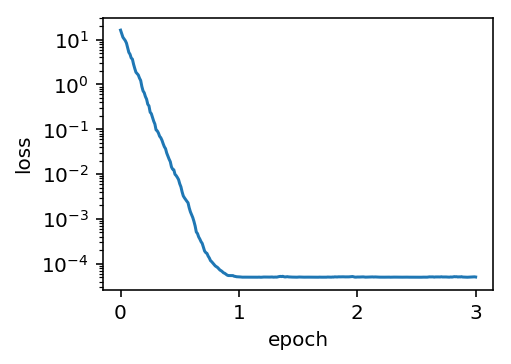

In [5]:
optimize(batch_size=10, rho=0.9999, num_epochs=3, log_interval=10)

## 小结

* Adadelta 没有学习率参数。


## 练习

* Adadelta 为什么不需要设置学习率超参数？它被什么代替了？


## 扫码直达 [ 讨论区 ](https://discuss.gluon.ai/t/topic/2277)

![](../img/qr_adadelta.svg)

## 参考文献

[1] Zeiler, M. D. (2012). ADADELTA: an adaptive learning rate method. arXiv preprint arXiv:1212.5701.